# LangGraph

`LangGraph` es un marco de orquestación de bajo nivel para construir agentes controlables

Mientras que `LangChain` proporciona integraciones y componentes para agilizar el desarrollo de aplicaciones LLM, la biblioteca `LangGraph` permite la orquestación de agentes, ofreciendo arquitecturas personalizables, memoria a largo plazo y `human in the loop` para manejar de manera confiable tareas complejas.

## ¿Cómo funciona `LangGraph`?

`LangGraph` se basa en tres componentes:

 * **Nodos**: Representan las unidades de procesamiento de la aplicación, como llamar a un LLM, o a una herramienta. Son funciones de Python que se ejecutan cuando se llama al nodo.
   * Toman el estado como entrada
   * Realizan alguna operación
   * Devuelven el estado actualizado
 * **Edges**: Representan las transiciones entre los nodos. Definen la lógica de cómo se va a ejecutar el grafo, es decir, qué nodo se va a ejecutar después de otro. Pueden ser:
   * Directos: Van de un nodo a otro
   * Condicionales: Dependen de una condición
 * **State**: Representa el estado de la aplicación, es decir, que contiene toda la información necesaria para la aplicación. Se mantiene durante la ejecución de la aplicación. Es definido por el usuario, así que hay que pensar muy bien qué se va a guardar en él.

![LangGraph concept](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/LangGraph_concept.webp)

Todos los grafos de `LangGraph` comienzan desde un nodo `START` y terminan en un nodo `END`.

## Instalación de LangGraph

Para instalar `LangGraph` se puede usar pip:

```bash
pip install -U langgraph
```

o instalar desde conda:

```bash
conda install langgraph
```

## Instalación de módulo de Hugging Face y Anthropic

Vamos a usar un modelo de lenguaje de `Hugging Face`, por lo que necesitamos instalar su paquete de langgraph.

```bash
pip install langchain-huggingface
```

Para una parte vamos a usar `Sonnet 3.7`, luego explicaremos por qué. Así que tambien instalamos el paquere de `Anthropic`.

```bash
pip install langchain_anthropic
```

## API KEY de Hugging Face

Vamos a usar `Qwen/Qwen2.5-72B-Instruct` a través de `Hugging Face Inference Endpoints`, por lo que necesitamos una API KEY.

Para poder usar el `Inference Endpoints` de HuggingFace, lo primero que necesitas es tener una cuenta en HuggingFace. Una vez la tengas, hay que ir a [Access tokens](https://huggingface.co/settings/keys) en la configuración de tu perfil y generar un nuevo token.

Hay que ponerle un nombre. En mi caso, le voy a poner `langgraph` y habilitar el permiso `Make calls to inference providers`. Nos creará un token que tendremos que copiar

Para gestionar el token, vamos a crear un archivo en la misma ruta en la que estemos trabajando llamado`.env` y vamos a poner el token que hemos copiado en el archivo de la siguiente manera:

``` bash
HUGGINGFACE_LANGGRAPH="hf_...."
```

Ahora, para poder obtener el token, necesitamos tener instalado `dotenv`, que lo instalamos mediante

```bash
pip install python-dotenv
```

Y ejecutamos lo siguiente

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

Ahora que tenemos un token, creamos un cliente. Para ello, necesitamos tener instalada la librería `huggingface_hub`. La instalamos mediante conda o pip.

``` bash
pip install --upgrade huggingface_hub
```

o

``` bash
conda install -c conda-forge huggingface_hub
```

Ahora tenemos que elegir qué modelo vamos a usar. Puedes ver los modelos disponibles en la página de [Supported models](https://huggingface.co/docs/api-inference/supported-models) de la documentación de `Inference Endpoints` de Hugging Face.

Vamos a usar `Qwen2.5-72B-Instruct` que es un modelo muy bueno.

In [2]:
MODEL = "Qwen/Qwen2.5-72B-Instruct"

Ahora podemos crear el cliente

In [3]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key=HUGGINGFACE_TOKEN, model=MODEL)
client

<InferenceClient(model='Qwen/Qwen2.5-72B-Instruct', timeout=None)>

Hacemos una prueba a ver si funciona

In [4]:
message = [
	{ "role": "user", "content": "Hola, qué tal?" }
]

stream = client.chat.completions.create(
	messages=message, 
	temperature=0.5,
	max_tokens=1024,
	top_p=0.7,
	stream=False
)

response = stream.choices[0].message.content
print(response)

¡Hola! Estoy bien, gracias por preguntar. ¿Cómo estás tú? ¿En qué puedo ayudarte hoy?


## API KEY de Anthropic

## Crear un chatbot básico

Vamos a crear un chatbot simple usando `LangGraph`. Este chatbot responderá directamente a los mensajes del usuario. Aunque es simple, nos servirá para ver los conceptos básicos de la construcción de grafos con `LangGraph`.

Como su nomre indica, `LangGraph` es una biblioteca para manejar grafos. así que comenzamos creando un grafo [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph).

Un `StateGraph` define la estructura de nuestro chatbot como una `máquina de estados`. Agregaremos `nodos` para representar el `llm` y `funciones` a nuestro chatbot que podrá llamar y `edges` para especificar cómo el bot debe hacer la transición entre estas funciones o `nodos`.

Así que comenzamos creando un `StateGraph` que necesita una clase `State` para manejar el estado del grafo. Como ahora vamos a crear una chatbot sencillo, solo necesitamos manejar una lista de mensajes en el estado.

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

La función [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) une dos listas de mensajes.

Llegarán nuevas listas de mensajes, por lo que se unirán a la lista de mensajes ya existente. Cada lista de mensajes contiene un `ID`, por lo que se agregan con este `ID`. Esto asegura que los mensajes solo se añaden, no se reemplazan, a no ser que un nuevo mensaje tenga el mismo `ID` que uno ya existente.

`add_messages` es una [reducer function](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers), es una función que se encarga de actualizar el estado.

El grafo `graph_builder` que hemos creado, recibe un estado `State` y devuelve un nuevo estado `State`. Además, actualiza la lista de mensajes.

 > **Concepto**
 >
 > Al definir un grafo, el primer paso es definir su `State`. El `State` incluye el esquema del grafo y las `reducer functions` que manejan actualizaciones del estado. 
 > 
 > En nuestro ejemplo, `State` es de tipo `TypedDict` (diccionario tipado) con una llave: `messages`.
 > 
 > `add_messages` es una `reducer function` que se utiliza para agregar nuevos mensajes a la lista en lugar de sobrescribirlos en la lista. Si una llave de un estado no tiene una `reducer function`, cada valor que llegue de esa clave sobrescribirán los valores anteriores.

Ahora vamos a agregar al grafo el nodo `chatbot`. Los nodos representan unidades de trabajo. Por lo general, son funciones regulares de `Python`.

Añadimos un nodo con el método `add_node` que recibe el nombre del nodo y la función que se ejecutará.

De modo que vamos a crear un LLM con HuggingFace, después crearemos un chat model con `LangChain` que hará referencia al LLM creado. Una vez tenemos definido un chat model, definimos la función que se ejecutará en el nodo de nuestro grafo. Esa función hará una llamada al chat model creado y devolverá el resultado.

In [4]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot_node", chatbot_function)

Hemos usado [ChatHuggingFace](https://python.langchain.com/api_reference/huggingface/chat_models/langchain_huggingface.chat_models.huggingface.ChatHuggingFace.html#langchain_huggingface.chat_models.huggingface.ChatHuggingFace) que es un chat del tipo [BaseChatModel](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html#langchain_core.language_models.chat_models.BaseChatModel) que es un tipo de chat base de `LangChain`. Una vez hemos creado el `BaseChatModel`, hemos creado la función `chatbot_function` que se ejecutará cuando se ejecute el nodo. Y por último, hemos creado el nodo `chatbot_node` y le hemos indicado que tiene que ejecutar la función `chatbot_function`.

 > **Aviso** 
 >
 > La función de nodo `chatbot_function` toma el estado `State` como entrada y devuelve un diccionario que contiene una actualización de la lista `messages` para la key `mensajes`. Este es el patrón básico para todas las funciones del nodo `LangGraph`.

La `reducer function` de nuestro grafo `add_messages` agregará los mensajes de respuesta del `llm` a cualquier mensaje que ya esté en el estado.

A continuación, agregamos un nodo `entry`. Esto le dice a nuestro grafo dónde empezar su trabajo cada vez que lo ejecutamos.

In [5]:
from langgraph.graph import START

graph_builder.add_edge(START, "chatbot_node")

Del mismo modo, añadimos un nodo `finish`. Esto indica al grafo `cada vez que se ejecuta este nodo, puede terminar el trabajo.`

In [6]:
from langgraph.graph import END

graph_builder.add_edge("chatbot_node", END)

Hemos importado `START` y `END` que podemos encontrarlos en [constants](https://langchain-ai.github.io/langgraph/reference/constants/) y el primer y último nodo de nuestro grafo.

Normalmente son nodos virtuales

Finalmente, queremos poder ejecutar nuestro grafo. Para hacerlo, usamos el método constructor de grafos `compile()`. Esto crea un `CompiledGraph` que podemos usar para ejecutar nuestra aplicación.

In [7]:
graph = graph_builder.compile()

Podemos visualizar el grafo usando el método `get_graph` y uno de los métodos de "dibujo", como `draw_ascii` o `draw_mermaid_png`. El dibujo de cada uno de los métodos requiere dependencias adicionales.

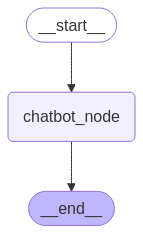

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

¡Ahora podemos probar el chatbot!

 > **Consejo**
 >
 > Puedes salir del bucle de chat en cualquier momento escribiendo `quit`, `exit` o `q`.

In [9]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{value['messages'][-1].content}")


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
            break
        
        events =stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Hello
Assistant: Hello! It's nice to meet you. How can I assist you today? Whether you have questions, need information, or just want to chat, I'm here to help!
User: How are you doing?
Assistant: I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with any questions or tasks you have! How can I assist you today?
User: Me well, I'm making a post about LangGraph, what do you think?
Assistant: LangGraph is an intriguing topic, especially if you're delving into the realm of graph-based models and their applications in natural language processing (NLP). LangGraph, as I understand, is a framework or tool that leverages graph theory to improve or provide a new perspective on NLP tasks such as text classification, information extraction, and semantic analysis. By representing textual information as graphs (nodes for entities and edges for relationships), it can offer a more nuanced understanding of the context and semantics in language data.

If you

**!Felicidades!** Has construido tu primer chatbot usando `LangGraph`. Este bot puede participar en una conversación básica tomando la entrada del usuario y generando respuestas utilizando el `LLM` que hemos definido.

Sin embargo, este bot se limita a lo que hay en sus datos de entrenamiento. Así que vamos a agregar una herramienta de búsqueda web para expandir el conocimiento del bot y hacerlo más capaz.

### Más

Hemos visto cómo crear un agente con un estado tipado mediante `TypedDict`, pero podemos crearlo con otro tipado. Si te interesa sigue leyendo, si no puedes pasar al siguiente punto de mejora del agente con herramientas

#### Tipado del estado

##### Tipado mediante `TypeDict`

Es la forma que hemos visto antes, tipamos el estado como un diccionario usando el tipado de Python `TypeDict`. Le pasamos una llave y un valor para cada variable de nuestro estado

``` python
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph

class State(TypedDict):
    messages: Annotated[list, add_messages]
```

Para acceder a los mensajes lo hacemos como con cualquier diccionario, mediante `state["messages"]`

##### Tipado mediante `dataclass`

Otra opción es usar el tipado de python `dataclass`

``` python
from dataclasses import dataclass
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph

@dataclass
class State:
    messages: Annotated[list, add_messages]
```

Como se puede ver es similar al tipado mediante diccionarios, pero ahora, al ser el estado un clase, accedemos a los mensajes mediante `state.mesages`

##### Tipado con `Pydantic`

`Pydantic` es una librería muy usada para tipar datos en Python. Nos ofrece la posibilidad de añadir una comprobación del tipado. Vamos a comprobar que el mensaje empiece con `'User'`, `'Assistant'` o `'System'`

``` python
from pydantic import BaseModel, field_validator, ValidationError
from typing import Annotated
from langgraph.graph.message import add_messages

class State(BaseModel):
    messages: Annotated[list, add_messages] # Should start by 'User', 'Assistant' or 'System'

    @field_validator('messages')
    @classmethod
    def validate_messages(cls, value):
        # Ensure the messages start with `User`, `Assistant` or `System`
        if not value.startswith["'User'"] and not value.startswith["'Assistant'"] and not value.startswith["'System'"]:
            raise ValueError("Message must to start with 'User', 'Assistant' or 'System'")
        return value

try:
    state = PydanticState(messages=["Hello"])
except ValidationError as e:
    print("Validation Error:", e)
```

#### Reducers

Como hemos dicho necesitamos usar una función de tipo `Reducer` para indicar cómo actualizar el estado, ya que si no el valor se sobreescribe

Vamos a ver un ejemplo de un grafo en el que no usamos una función de tipo `Reducer` para indicar cómo actualizar el estado

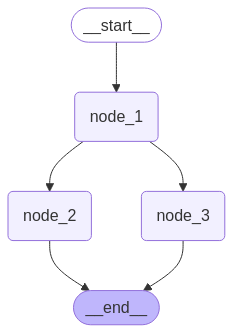

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Como vemos hemos definido un grafo en el que primero se ejecuta el nodo 1 y luego el 2 y el 3. Vamos a ejecutarlo a ver qué pasa

In [6]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


Obtenemos un error porque primero el nodo 1 modifica el valor de `foo` y luego los nodos 2 y 3 intentan modificar el valor de `foo` en paralelo, lo cual da un error

Así que para evitar eso usamos una función de tipo `Reducer` para indicar cómo modificar el estado

##### Reducers predefinidos

Usamos el tipo `Annotated` para especificar que es una función de tipo `Reducer`. Y usamos el operador `add` para concatenar un valor en una lista

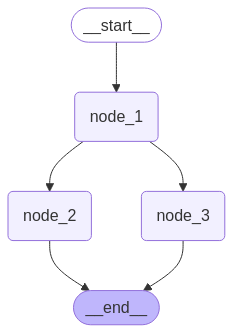

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Lo volvemos a ejecutar a ver qué pasa

In [8]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

Como vemos inicializamos el valor de `foo` a 1, lo cual se añade en una lista. Luego el nodo 1 le suma 1 y lo añade como nuevo valor en la lista, es decir, añade un 2. Por último los nodos 2 y 3 suman uno al último valor de la lista, es decir, los dos nodos obtienen un 3 y los dos nodos lo añaden al final de la lista, por eso la lista resultante tiene dos 3 al final

Como hemos definido `foo` como una lista de enteros, y está tipado, si inicializamos el estado con `None` obtenemos un error

In [9]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


##### Reducers personalizados

A veces no podemos usar un `Reducer` predefinido y tenemos que crearnos el nuestro

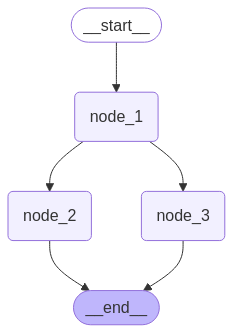

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Annotated

def reducer_function(current_list, new_item: list | None):
    if current_list is None:
        current_list = []

    if new_item is not None:
        return current_list + new_item
    return current_list

class State(TypedDict):
    foo: Annotated[list[int], reducer_function]

def node_1(state):
    print("---Node 1---")
    if len(state['foo']) == 0:
        return {'foo': [0]}
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---


#### Múltiples estados

Supongamos que queremos ocultar variables del estado, por la razón que sea, porque algunas variables solo aportan ruido o porque queremos mantener alguna variable privada.

##### Estados privados

Si queremos tener un estado privado, simplemente lo creamos.

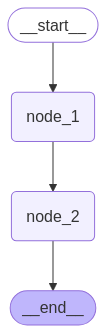

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    public_var: int

class PrivateState(TypedDict):
    private_var: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"private_var": state['public_var'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"public_var": state['private_var'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Como vemos hemos creado el estado privado `PrivateState` y el estado público `OverallState`. Cada uno con una variable privada y una pública. Primero se ejecuta el nodo 1, que modifica la variable privada y la devuelve. Luego se ejecuta el nodo 2, que modifica la variable pública y la devuelve. Vamos a ejecutar el grafo para ver qué pasa

In [2]:
graph.invoke({"public_var" : 1})

---Node 1---
---Node 2---


{'public_var': 3}

Como vemos al ejecutar el grafo, pasamos la variable pública `public_var` y obtenemos a la salida otra variable pública `public_var` con el valor modificado, pero nunca se ha accedido a la variable privada `private_var`

##### Estados de entrada y salida

Podemos definir las variables de entrada y salida del grafo. Aunque internamente el estado puede tener más variables, definimos qué variables son de entrada al grafo y qué variables son de salida.

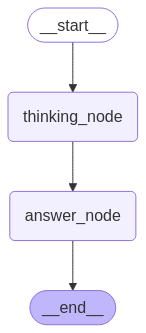

In [3]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

En este caso el estado tiene 3 variables, `question`, `answer` y `notes`. Sin embargo definimos como entrada al grafo `question` y como salida del grafo `answer`. Por lo tanto, el estado interno puede tener más variables, pero no se tienen en cuenta a la hora de invocar el grafo. Vamos a ejecutar el grafo para ver qué pasa

In [4]:
graph.invoke({"question":"hi"})

{'answer': 'bye Lance'}

Como vemos, le hemos metido `question` al grafo y hemos obtenido `answer` a la salida.

#### Manejo del contexto

Vamos a volver a ver el código del chatbot básico

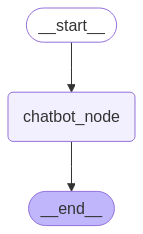

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chatbot_function)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Vamos a crear un contexto que le pasaremos al modelo

In [9]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Si se lo pasamos al grafo obtendremos la salida

In [10]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great topic! Besides whales, there are several other fascinating ocean mammals you might want to learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social, dolphins are found in all oceans of the world. They are known for their playful behavior and communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and stouter, porpoises are less social and more elusive. They are found in coastal waters around the world.

3. **Seals and Sea Lions**: These are semi-aquatic mammals that can be found in both Arctic and Antarctic regions, as well as in more temperate waters.

Como vemos ahora a la salida tenemos un mensaje más.

Si esto sigue creciendo llegará un momento en el que tendremos un contexto muy largo, por lo que supondrá un mayor gasto de tokens, que puede acarrear un mayor gasto económico, conlleva también mayor latencia.

Además con contextos muy largos los LLMs empiezan a rendir peor.

Los últimos modelos, a día de la escritura de este post, por encima de 8k tokens como contexto, empieza a decaer el rendimiento del LLM

Así que vamos a ver varias maneras de gestionar esto

##### Modificar el contexto con funciones de tipo `Reducer`

Hemos visto que con las funciones de tipo `Reducer` podemos modificar los mensajes del estado

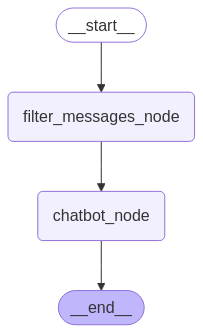

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import RemoveMessage
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def filter_messages(state: State):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: State):    
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("filter_messages_node", filter_messages)
graph_builder.add_node("chatbot_node", chat_model_node)

# Connecto nodes
graph_builder.add_edge(START, "filter_messages_node")
graph_builder.add_edge("filter_messages_node", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Como vemos en el grafo, primero filtramos los mensajes y luego pasamos el resultado al modelo.

Volvemos a crear un contexto que le pasaremos al modelo, pero ahora con más mensajes

In [32]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))
messages.append(AIMessage(f"I know about sharks too", name="Bot"))
messages.append(HumanMessage(f"What others should I learn about?", name="Lance"))
messages.append(AIMessage(f"I know about dolphins too", name="Bot"))
messages.append(HumanMessage(f"Tell me more about dolphins", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about sharks too
================================ Human Message =================================
Name: Lance

What others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about dolphins too
================================ Human Message =================================
Name: Lance

Tell me more about dolphins


Si se lo pasamos al grafo obtendremos la salida

In [33]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

I know about dolphins too
================================ Human Message =================================
Name: Lance

Tell me more about dolphins
================================== Ai Message ==================================

Dolphins are highly intelligent marine mammals that are part of the family Delphinidae, which includes about 40 species. They are found in oceans worldwide, from tropical to temperate regions, and are known for their agility and playful behavior. Here are some interesting facts about dolphins:

1. **Social Behavior**: Dolphins are highly social animals and often live in groups called pods, which can range from a few individuals to several hundred. Social interactions are complex and include cooperative behaviors, such as hunting and defending against predators.

2. **Communication**: Dolphins communicate using a variety of sounds, including clicks, whistles, and body la

Como se puede ver, se ha pasado como contexto los dos últimos mensajes.

##### Recortar mensajes

Otra solución es recortar cada mensaje de la lista de mensajes, se establece un límite de tokens y se elimina el mensaje que supera ese límite.

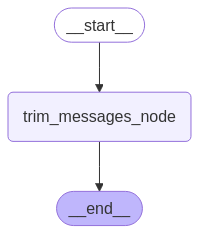

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import trim_messages
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def trim_messages_node(state: State):
    # Trim the messages based on the specified parameters
    trimmed_messages = trim_messages(
        state["messages"],
        max_tokens=100,       # Maximum tokens allowed in the trimmed list
        strategy="last",     # Keep the latest messages
        token_counter=llm,   # Use the LLM's tokenizer to count tokens
        allow_partial=True,  # Allow cutting messages mid-way if needed
    )

    # Print the trimmed messages to see the effect of trim_messages
    print("--- trimmed messages (input to LLM) ---")
    for m in trimmed_messages:
        m.pretty_print()
    print("------------------------------------------------")

    # Invoke the LLM with the trimmed messages
    response = llm.invoke(trimmed_messages)

    # Return the LLM's response in the correct state format
    return {"messages": [response]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("trim_messages_node", trim_messages_node)

# Connecto nodes
graph_builder.add_edge(START, "trim_messages_node")
graph_builder.add_edge("trim_messages_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Como vemos en el grafo, primero filtramos los mensajes y luego pasamos el resultado al modelo.

Volvemos a crear un contexto que le pasaremos al modelo, pero ahora con más mensajes

In [2]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))
messages.append(AIMessage(f"""I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is the most dangerous.
The tiger shark is the most aggressive of the sharks and is the most dangerous.
The hammerhead shark is the most beautiful of the sharks and is the most dangerous.
The mako shark is the fastest of the sharks and is the most dangerous.
The bull shark is the most common of the sharks and is the most dangerous.
""", name="Bot"))
messages.append(HumanMessage(f"What others should I learn about?", name="Lance"))
messages.append(AIMessage(f"I know about dolphins too", name="Bot"))
messages.append(HumanMessage(f"Tell me more about dolphins", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is th

Si se lo pasamos al grafo obtendremos la salida

In [4]:
output = graph.invoke({'messages': messages})

--- trimmed messages (input to LLM) ---
================================== Ai Message ==================================
Name: Bot

The tiger shark is the most aggressive of the sharks and is the most dangerous.
The hammerhead shark is the most beautiful of the sharks and is the most dangerous.
The mako shark is the fastest of the sharks and is the most dangerous.
The bull shark is the most common of the sharks and is the most dangerous.
================================ Human Message =================================
Name: Lance

What others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about dolphins too
================================ Human Message =================================
Name: Lance

Tell me more about dolphins
------------------------------------------------


Como se puede ver se ha recortado el contexto que se le pasa al LLM, vamos a ver la salida del LLM

In [5]:
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is th

Con un contexto recortado el LLM sigue contestando

##### Modificación del contexto y recorte de mensajes

Vamos a juntar las dos técnicas anteriores, modificaremos el contexto y recortaremos los mensajes.

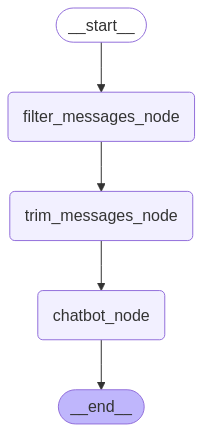

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import RemoveMessage, trim_messages
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def filter_messages(state: State):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def trim_messages_node(state: State):
    # print the messages
    print("--- messages (input to trim_messages) ---")
    for m in state["messages"]:
        m.pretty_print()
    print("------------------------------------------------")

    # Trim the messages based on the specified parameters
    trimmed_messages = trim_messages(
        state["messages"],
        max_tokens=100,       # Maximum tokens allowed in the trimmed list
        strategy="last",     # Keep the latest messages
        token_counter=llm,   # Use the LLM's tokenizer to count tokens
        allow_partial=True,  # Allow cutting messages mid-way if needed
    )

    # Print the trimmed messages to see the effect of trim_messages
    print("--- trimmed messages (input to LLM) ---")
    for m in trimmed_messages:
        m.pretty_print()
    print("------------------------------------------------")

    # Invoke the LLM with the trimmed messages
    response = llm.invoke(trimmed_messages)

    # Return the LLM's response in the correct state format
    return {"messages": [response]}

def chat_model_node(state: State):    
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("filter_messages_node", filter_messages)
graph_builder.add_node("chatbot_node", chat_model_node)
graph_builder.add_node("trim_messages_node", trim_messages_node)

# Connecto nodes
graph_builder.add_edge(START, "filter_messages_node")
graph_builder.add_edge("filter_messages_node", "trim_messages_node")
graph_builder.add_edge("trim_messages_node", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Ahora filtramos quedándonos con los dos últimos mensajes, luego trimamos el contexto para que no se gasten muchos tokens y finalmente pasamos el resultado al modelo.

Creamos un contexto para pasárselo al grafo

In [8]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))
messages.append(AIMessage(f"I know about dolphins too", name="Bot"))
messages.append(HumanMessage(f"What others should I learn about?", name="Lance"))
messages.append(AIMessage(f"""I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is the most dangerous.
The tiger shark is the most aggressive of the sharks and is the most dangerous.
The hammerhead shark is the most beautiful of the sharks and is the most dangerous.
The mako shark is the fastest of the sharks and is the most dangerous.
The bull shark is the most common of the sharks and is the most dangerous.
""", name="Bot"))
messages.append(HumanMessage(f"What others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about dolphins too
================================ Human Message =================================
Name: Lance

What others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups

Se lo pasamos al grafo y obtenemos la salida

In [9]:
output = graph.invoke({'messages': messages})

--- messages (input to trim_messages) ---
================================== Ai Message ==================================
Name: Bot

I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is the most dangerous.
The tiger shark is the most aggressive of the sharks and is the most dangerous.
The hammerhead shark is the most beautiful of the sharks and is the most dangerous.
The mako shark is the fastest of the sharks and is the most dangerous.
The

Como se ve solo nos hemos quedado con el último mensaje, el filtrado ha devuelto los dos últimos mensajes, pero el trimado ha eliminado el penúltimo mensaje por tener más de 100 tokens.

Vamos a ver qué tenemos a la salida del modelo

In [10]:
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is the most dangerous.
The tiger shark is the most aggressive of the sharks and is the most dangerous.
The hammerhead shark is the most beautiful of the sharks and is the most dangerous.
The mako shark is the fastest of the sharks and is the most dangerous.
The bull shark is the most common of the shar

Hemos filtrado tanto el estado que el LLM no tiene contexto suficiente, esto lo vamos a solucionar con la siguiente técnica.

#### Modos de streaming

##### Streaming síncrono

En este caso vamos a recibir el resultado del LLM completo de una vez haya terminado de generar el texto.

Para explicar los modos de streaming sícrono, primero vamos a crear un grafo básico.

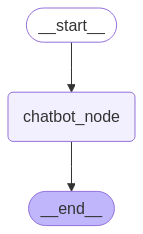

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import HumanMessage
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def chat_model_node(state: State):
    # Return the LLM's response in the correct state format
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Ahora tenemos dos maneras de obtener el resultado del LLM, una es mediante el modo `updates` y la otra mediante el modo `values`.

![updates vs values](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Mientras que `updates` nos da cada nuevo resultado, `values` nos da todo el historial de resultados.

###### Updates

In [2]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Máximo")]}, stream_mode="updates"):
    print(chunk['chatbot_node']['messages'][-1].content)

Hello Máximo! It's nice to meet you. How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific.


###### Values

In [3]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Máximo")]}, stream_mode="values"):
    print(chunk['messages'][-1].content)

hi! I'm Máximo
Hello Máximo! It's nice to meet you. How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific.


##### Streaming asíncrono

Ahora vamos a recibir el resultado del LLM token a token. Para ello tenemos que añadir `streaming=True` cuando creamos el LLM de HuggingFace y tenemos que cambiar la función del nodo del chatbot para que sea asíncrona.

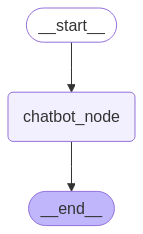

In [13]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import HumanMessage
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    streaming=True,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
async def chat_model_node(state: State):
    async for token in llm.astream_log(state["messages"]):
        yield {"messages": [token]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Como se puede ver la función se ha creado asíncrona y se ha convertido en una generador ya que el `yield` devuelve un valor y pausa la ejecución de la función hasta que se llame de nuevo.

Vamos a ejecutar el grafo de forma aíncrona y vemos los tipos de eventos que se generan.

In [7]:
try:
    async for event in graph.astream_events({"messages": [HumanMessage(content="hi! I'm Máximo")]}, version="v2"):
        print(f"event: {event}")
except Exception as e:
    print(f"Error: {e}")

event: {'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="hi! I'm Máximo", additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'c9c40a00-157a-4229-a0d1-fda00e7bfd34', 'metadata': {}, 'parent_ids': []}
event: {'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="hi! I'm Máximo", additional_kwargs={}, response_metadata={}, id='6469501c-07b0-42e4-a3e6-f133ace1860c')]}}, 'name': 'chatbot_node', 'tags': ['graph:step:1'], 'run_id': '638828c0-4add-4141-b6b6-484446100237', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'chatbot_node', 'langgraph_triggers': ('branch:to:chatbot_node',), 'langgraph_path': ('__pregel_pull', 'chatbot_node'), 'langgraph_checkpoint_ns': 'chatbot_node:b7599990-0c1a-4133-fb2c-f32105784fbd'}, 'parent_ids': ['c9c40a00-157a-4229-a0d1-fda00e7bfd34']}
event: {'event': 'on_chain_start', 'data': {}, 'name': 'chatbot_node', 'tags': ['seq:step:1'], 'run_id': '15247b1a-1cd6-486

/Users/macm1/miniforge3/envs/langgraph/lib/python3.13/site-packages/huggingface_hub/inference/_generated/_async_client.py:2308: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


event: {'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content=' or', additional_kwargs={}, response_metadata={})}, 'run_id': '74dfdbb9-4c2d-4a08-ad7d-795b5953cae3', 'name': 'ChatHuggingFace', 'tags': [], 'metadata': {'langgraph_step': 1, 'langgraph_node': 'chatbot_node', 'langgraph_triggers': ('branch:to:chatbot_node',), 'langgraph_path': ('__pregel_pull', 'chatbot_node'), 'langgraph_checkpoint_ns': 'chatbot_node:b7599990-0c1a-4133-fb2c-f32105784fbd', 'checkpoint_ns': 'chatbot_node:b7599990-0c1a-4133-fb2c-f32105784fbd', 'ls_provider': 'huggingface', 'ls_model_type': 'chat'}, 'parent_ids': ['c9c40a00-157a-4229-a0d1-fda00e7bfd34', '638828c0-4add-4141-b6b6-484446100237', '15247b1a-1cd6-4863-9402-66499f921244']}
event: {'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content=' let', additional_kwargs={}, response_metadata={})}, 'run_id': '74dfdbb9-4c2d-4a08-ad7d-795b5953cae3', 'name': 'ChatHuggingFace', 'tags': [], 'metadata': {'langgraph_step': 1, 'la

Como se puede ver los tokens llegan con el evento `on_chat_model_stream`, así que vamos a capturarlo e imprimirlo.

In [14]:
try:
    async for event in graph.astream_events({"messages": [HumanMessage(content="hi! I'm Máximo")]}, version="v2"):
        if event["event"] == "on_chat_model_stream":
            print(event["data"]["chunk"].content, end=" | ", flush=True)
except Exception as e:
    pass

/Users/macm1/miniforge3/envs/langgraph/lib/python3.13/site-packages/huggingface_hub/inference/_generated/_async_client.py:2308: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


Hello |  Má | ximo | ! |  It | 's |  nice |  to |  meet |  you | . |  How |  can |  I |  assist |  you |  today | ? |  Feel |  free |  to |  ask |  me |  any |  questions |  or |  let |  me |  know |  if |  you |  need |  help |  with |  anything |  specific | . | <|im_end|> | 

## Mejorar el chatbot con herramientas

Para manejar algunas consultas, nuestro chatbot no puede responder `desde su conocimiento`, así que vamos a integrar una herramienta de búsqueda web. Nuestro bot puede utilizar esta herramienta para encontrar información relevante y proporcionar mejores respuestas.

### Requisitos

Antes de comenzar, tenemos que instalar el buscador [Tavily](https://python.langchain.com/docs/integrations/tools/tavily_search/) que es un buscador web que nos permite buscar información en la web.

```bash
pip install -U tavily-python langchain_community
```

Después, tenemos que crear una [API KEY](https://app.tavily.com/home), la escribimos en nuestro archivo `.env` y la cargamos en una variable.

In [1]:
import dotenv
import os

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

Ahora, definimos la herramienta de búsqueda web mediante [TavilySearchResults](https://python.langchain.com/api_reference/community/tools/langchain_community.tools.tavily_search.tool.TavilySearchResults.html)

In [2]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

Probamos la herramienta, vamos a hacer una búsqueda en internet

In [3]:
tool.invoke("What was the result of Real Madrid's at last match in the Champions League?")

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[{'title': 'HIGHLIGHTS | Real Madrid 3-2 Leganés | LaLiga 2024/25 - YouTube',
  'url': 'https://www.youtube.com/watch?v=Np-Kwz4RDpY',
  'content': "20:14 · Go to channel · RONALDO'S LAST MATCH WITH REAL MADRID: THE MOST THRILLING FINAL EVER! ... Champions League 1/4 Final | PES. Football",
  'score': 0.65835214},
 {'title': 'Real Madrid | History | UEFA Champions League',
  'url': 'https://www.uefa.com/uefachampionsleague/history/clubs/50051--real-madrid/',
  'content': '1955/56 P W D L Final 7 5 0 2\nUEFA Champions League [...] 2010/11 P W D L Semi-finals 12 8 3 1\n2009/10 P W D L Round of 16 8 4 2 2\n2000s\n2008/09 P W D L Round of 16 8 4 0 4\n2007/08 P W D L Round of 16 8 3 2 3\n2006/07 P W D L Round of 16 8 4 2 2\n2005/06 P W D L Round of 16 8 3 2 3\n2004/05 P W D L Round of 16 10 6 2 2\n2003/04 P W D L Quarter-finals 10 6 3 1\n2002/03 P W D L Semi-finals 16 7 5 4\n2001/02 P W D L Final 17 12 3 2\n2000/01 P W D L Semi-finals 16 9 2 5\n1990s\n1999/00 P W D L Final 17 10 3 4\n1998/99

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart i

Los resultados son resúmenes de páginas que nuestro chatbot puede usar para responder preguntas.

Creamos una lista de herramientas, porque nuestro grafo necesita definir las herramientas mediante una lista.

In [4]:
tools_list = [tool]

Comenzaremos a definir nuestro gráfico. Lo siguiente es todo lo mismo que antes, excepto que hemos añadido `bind_tools` en nuestro `LLM`. Esto le permite al `LLM` saber el formato `JSON` correcto para usar si desea usar el motor de búsqueda.

Definimos el grafo

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

A continuación el `LLM` con las `bind_tools` y lo añadimos al grafo

In [6]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Necesitamos crear una función para ejecutar las `tools_list` si se llaman. Agregamos las `tools_list` a un nuevo nodo.

Vamos a implementar la clase `BasicToolNode`, que comprueba el mensaje más reciente en el estado y llama a las `tools_list` si el mensaje contiene `tool_calls`.

Se basa en el soporte de `tool_calling` de los `LLM`s , que está disponible en `Anthropic`, `HuggingFace`, `Google Gemini` y varios otros proveedores de `LLM`.

Más tarde reemplazaremos esto con el método [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) de `LangGraph` para acelerar las cosas, pero primero lo construiremos nosotros mismos para entender cómo funciona.

Una de las cosas que usa `LangGraph` para entender 

In [7]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        """
        Initialize the tools

        Args:
            tools (list): The tools to use

        Returns:
            None
        """
        # Initialize the tools
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """
        Call the node

        Args:
            inputs (dict): The inputs to the node

        Returns:
            dict: The outputs of the node
        """
        # Get the last message
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        
        # Execute the tools
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


basic_tool_node = BasicToolNode(tools=tools_list)
graph_builder.add_node("tools_node", basic_tool_node)

Hemos usado [ToolMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.tool.ToolMessage.html) que pasa el resultado de ejecutar una `tool` de nuevo al `LLM`.

`ToolMessage` contiene el resultado de una invocación de una `tool`.

Es decir, en cuanto tenemos el resultado de usar una `Tool` se lo pasamos al LLM para que lo procese

Con el nodo de `basic_tool_node` (que es un objeto de la clase `BasicToolNode` que hemos creado) agregado al grafo, podemos definir los `conditional_edges`.

El `enrutador` enruta el flujo de control de un nodo al siguiente. Los `conditional_edges` por lo general, contienen declaraciones `if` para enrutar a diferentes nodos dependiendo del estado actual del grafo.

Estas funciones reciben el grafo actual `state` y devuelven una cadena o lista de cadenas que indican qué nodo o nodos llamar a continuación.

Vamos a definir una función de enrutadora llamada `route_tools_function`, que comprueba si hay `tool_calls` en la salida del chatbot.

Añadimos esta función al gráfico llamando `add_conditional_edges`, que le dice al grafo que cada vez que el nodo del `basic_tool_node` se ejecuta, se llama a la función para verificar a dónde ir a continuación.

La condición se dirigirá a `tools_node` si las llamadas de herramientas están presentes y `END` si no.

Más tarde, reemplazaremos esto con el método preconstruido `tools_condition` para ser más rápidos, pero ahora lo implementamos nosotros mismos primero ver cómo funciona.

In [8]:
def route_tools_function(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    # Get las message
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # Router in function of last message
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools_node"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot_node",
    route_tools_function,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools_node": "tools_node", END: END},
)

Como el método de `LangGraph` ya existente `tools_condition`, nuestra función devuelve `END` si no se realizan llamadas de `tool`s. Cuando el grafo pasa a `END` éste no tiene más tareas que completar y cesa la ejecución.

Como la condición puede devolver `END`, no necesitamos establecer explícitamente un `finish_point` esta vez. Nuestro grafo ya tiene una manera de terminar

In [9]:
graph_builder.add_edge("tools_node", "chatbot_node")

Añadimos un otro nodo `edge`, pero en este caso incluye el uso de la `tool` o en final `END`

In [10]:
graph_builder.add_edge(START, "chatbot_node")

 > **Aviso** 
 >
 > Los `conditional_edge`s comienzan desde un solo nodo. Esto le dice al grafo "en cualquier momento el 'chatbot' se ejecuta el nodo, ve a las 'tools' si se llama a una herramienta o termina el bucle si responde directamente".

Compilamos el grafo

In [11]:
graph = graph_builder.compile()

Visualizamos el grafo que hemos construido.

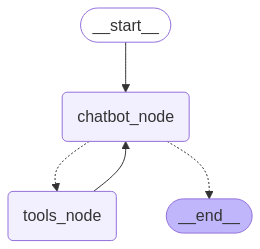

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Ahora podemos hacer preguntas al bot fuera de sus datos de entrenamiento

In [15]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{value['messages'][-1].content}")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: How did Real Madrid fare this weekend against Leganes in La Liga?
Assistant: 
User: How did Real Madrid fare this weekend against Leganes in La Liga?
Assistant: [{"title": "Real Madrid 3-2 Leganes: Goals and highlights - LaLiga 24/25 | Marca", "url": "https://www.marca.com/en/soccer/laliga/r-madrid-leganes/2025/03/29/01_0101_20250329_186_957-live.html", "content": "While their form has varied throughout the campaign there is no denying Real Madrid are a force at home in LaLiga this season, as they head into Saturday's match having picked up 34 points from 13 matches.\n\nAs for Leganes they currently sit 18th in the table, though they are level with Alaves for 17th as both teams look to stay in the top flight. [...] The two teams have already played twice this season, with Real Madrid securing a 3-0 win in the reverse league fixture. They also met in the quarter-finals of the Copa del Rey, a game Real won 3-2.\n\nReal Madrid vs Leganes LIVE - Latest Updates\n\nMatch ends, Real Mad

Como ves, primero le he preguntado cómo quedó el Real Madrid en su último partido en la Liga contra el Leganés
, como es algo de actualidad, ha decidido usar la herramienta de búsqueda, con lo que ha obtenido el resultado

Sin embargo, a continuación le he preguntado qué jugadores jugaron y no sabía de qué le hablaba, eso es porque no se mantiene el contexto de la conversación. Así que lo siguiente que vamos a hacer es agregar una memoria al agente para que pueda mantener el contexto de la conversación.

## Agregar memoria al chatbot

Nuestro chatbot ahora puede usar herramientas para responder preguntas de los usuarios, pero no recuerda el contexto de las interacciones anteriores. Esto limita su capacidad de tener conversaciones coherentes y de múltiples tandas.

`LangGraph` resuelve este problema a través de puntos de control persistentes o `checkpoints`. Si le proporcionamos un `checkpointer` al compilar el grafo y un `thread_id` al llamar al grafo, `LangGraph` guarda automáticamente el estado después de cada iteración en la conversación.

Cuando invoquemos el grafo nuevamente usando el mismo `thread_id`, el grafo cargará su estado guardado, permitiendo que el chatbot continúe donde lo dejó.

Veremos más tarde que ese `checkpointing` es mucho más potente que la simple memoria de chat: le permite guardar y reanudar estados complejos en cualquier momento para la recuperación de errores, flujos de trabajo con `human in the loop`, interacciones en el tiempo y más. Pero antes de ver todo eso, vamos a agregar puntos de control para permitir conversaciones de varias iteraciones.

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

Para empezar, creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [2]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

 > **Aviso**
 >
 > Estamos usando un `checkpointer` en memoria. Esto es conveniente para nuestro caso, ya que lo guarda todo en memoria la memoria del ordenador. En una aplicación de producción, es probable que se necesite cambiar esto para usarlo con `SqliteSaver` o `PostgresSaver` y conéctarnos a nuestra propia base de datos.

A continuación, definimos el grafo.

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Definimos la `tool`

In [4]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)
tools_list = [tool]

A continuación el `LLM` con las `bind_tools` y lo añadimos al grafo

In [5]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Antes construimos nuestro propio `BasicToolNode` para aprender cómo funciona, ahora lo reemplazaremos con el método de LangGraph `ToolNode` y `tools_condition`, ya que estos hacen algunas cosas buenas como la ejecución paralela de API. Aparte de eso, el resto es igual que antes.

In [6]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Añadimos el nodo de `tools_condition` al grafo

In [7]:
graph_builder.add_conditional_edges(
    "chatbot_node",
    tools_condition,
)

Añadimos el nodo de `tools` al grafo

In [8]:
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [9]:
graph_builder.add_edge(START, "chatbot_node")

Compilamos el grafo añadiendo el `checkpointer`

In [10]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

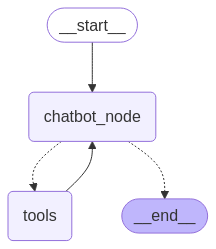

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Creamos una configuración con un `thread_id` de un usuario

In [12]:
USER1_THREAD_ID = "1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}

In [14]:
user_input = "Hi there! My name is Maximo."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Maximo.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query:  does not reside in any location,}},
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Determining an individual's tax residency status - IRS", "url": "https://www.irs.gov/individuals/international-taxpayers/determining-an-individuals-tax-residency-status", "content": "If you are not a U.S. citizen, you are considered a nonresident of the United States for U.S. tax purposes unless you meet one of two tests.", "score": 0.1508904}, {"title": "Fix \"Location Is Not Available\", C:\\WINDOWS\\system32 ... - YouTube", "url": "https://www.youtube.com/watch?v=QFD-Ptp0SJw", "content": "Fix Error \"Location is not available\" C:\\WINDOWS\\system32\\config\\

In [15]:
user_input = "Do you remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Of course! You mentioned your name is Maximo.


Como se puede ver, no hemos pasado una lista con los mensakes, todo está siendo gestionado por el `checkpointer`.

Si ahora probamos con otro usuario, es decir, con otro `thread_id`, veremos que el grafo no recuerda la conversación anterior.

In [16]:
USER2_THREAD_ID = "2"
config_USER2 = {"configurable": {"thread_id": USER2_THREAD_ID}}

user_input = "Do you remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER2,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: Do you Remember My Name
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Sam Fender - Remember My Name (Official Video) - YouTube", "url": "https://www.youtube.com/watch?v=uaQm48G6IjY", "content": "Sam Fender - Remember My Name (Official Video) \n SamFenderVEVO \n 10743 likes \n 862209 views \n 14 Feb 2025 \n Remember My Name is a love song dedicated to my late Grandparents - they were always so fiercely proud of our family so I wrote the song in honour of them, from the perspective of my Grandad who was looking after my Grandma when she was suffering from dementia. This video is a really special one for me and I want to say thank you to everyone inv

Ahora que nuestro chatbot tiene herramientas de búsqueda y memoria, vamos a repetir el ejemplo anterior, donde le pregunto por el resultado del último partido del Real Madrid en la Liga y luego por qué jugadores jugaron.

In [17]:
USER3_THREAD_ID = "3"
config_USER3 = {"configurable": {"thread_id": USER3_THREAD_ID}}

user_input = "How did Real Madrid fare this weekend against Leganes in La Liga?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER3,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How did Real Madrid fare this weekend against Leganes in La Liga?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: Real Madrid vs Leganes La Liga this weekend
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Real Madrid 3-2 Leganes: Goals and highlights - LaLiga 24/25 | Marca", "url": "https://www.marca.com/en/soccer/laliga/r-madrid-leganes/2025/03/29/01_0101_20250329_186_957-live.html", "content": "While their form has varied throughout the campaign there is no denying Real Madrid are a force at home in LaLiga this season, as they head into Saturday's match having picked up 34 points from 13 matches.\n\nAs for Leganes they currently sit 18th in the table, though they are level with Alaves for 17th as both teams look to st

Ahora le preguntamos por los jugadores que jugaron en el partido.

In [18]:
user_input = "Which players played the match?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER3,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Which players played the match?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: Real Madrid vs Leganes match report players lineup
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Real Madrid vs. Leganes final score: La Liga result, updates, stats ...", "url": "https://www.sportingnews.com/us/soccer/news/real-madrid-leganes-score-result-updates-stats-la-liga/8ecf730cfcb9b6c5f6693a0d", "content": "Real Madrid came through a topsy-turvy game with Leganes to claim a 3-2 victory and put pressure back on Barcelona in La Liga's title race. Kylian Mbappe scored in each half either side of a Jude Bellingham goal — his first in the league since January 3 — to seal all three points for the champions after Leganes had come from behi

Tras mucho buscar, al final lo encuentra. Por lo que ya tenemos un chatbot con `tools` y memoria.

Por ahora, hemos creado unos `checkpoints` en tres hilos diferentes. Pero, ¿qué entra en cada `checkpoint`? Para inspeccionar el estado de un grafo para una configuración dada podemos usar el método `get_state(config)`.

In [19]:
snapshot = graph.get_state(config_USER3)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='How did Real Madrid fare this weekend against Leganes in La Liga?', additional_kwargs={}, response_metadata={}, id='a33f5825-1ae4-4717-ad17-8e306f35b027'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': {'query': 'Real Madrid vs Leganes La Liga this weekend'}, 'name': 'tavily_search_results_json', 'description': None}, 'id': '0', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 296, 'total_tokens': 321}, 'model': '', 'finish_reason': 'stop'}, id='run-7905b5ae-5dee-4641-b012-396affde984c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Real Madrid vs Leganes La Liga this weekend'}, 'id': '0', 'type': 'tool_call'}]), ToolMessage(content='[{"title": "Real Madrid 3-2 Leganes: Goals and highlights - LaLiga 24/25 | Marca", "url": "https://www.marca.com/en/soccer/laliga/r-madrid-leganes/2025/03/29/01_0101_20250329_186_957-live

Si queremos ver el siguiente nodo a procesar, podemos usar el atributo `next`

In [20]:
snapshot.next

()

dado que el grafo ha finalizado, `next` está vacío. Si obtienes un estado desde dentro de una invocación del grafo, next indica qué nodo se ejecutará a continuación.

La instantánea anterior (`snapshot`) contiene los valores de estado actuales, la configuración correspondiente y el siguiente nodo (`next`) a procesar. En nuestro caso, el gráfico ha alcanzado el estado `END`, por eso `next` está vacío.

**¡Felicidades!** Nuestro chatbot ahora puede mantener el estado de conversación en todas las sesiones gracias al sistema de puntos de control (`checkpoints`) de `LangGraph`. Esto abre posibilidades para interacciones más naturales y contextuales. El control de `LangGraph` incluso maneja estados de grafos complejos.

### Más

#### Chatbot con mensaje de resumen

Si vamos a manejar el contexto de la conversación para no gastar muchos tokens, una cosa que podemos hacer para mejorar la conversación es añadir un mensaje con el resumen de la conversación. Esto puede ser útil para el ejemplo anterior, en el que hemos filtrado tanto el estado que el LLM no tiene contexto suficiente.

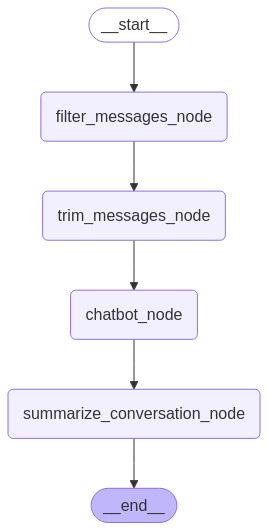

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import RemoveMessage, trim_messages, SystemMessage, HumanMessage, AIMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

memory_saver = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    summary: str

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Print functions
def print_message(m):
    if isinstance(m, HumanMessage):
        message_content = m.content
        message_lines = message_content.split("\n")
        for i, line in enumerate(message_lines):
            if i == 0:
                print(f"\t\t[HumanMessage]: {line}")
            else:
                print(f"\t\t{line}")
    elif isinstance(m, SystemMessage):
        message_content = m.content
        message_lines = message_content.split("\n")
        for i, line in enumerate(message_lines):
            if i == 0:
                print(f"\t\t[SystemMessage]: {line}")
            else:
                print(f"\t\t{line}")
    elif isinstance(m, AIMessage):
        message_content = m.content
        message_lines = message_content.split("\n")
        for i, line in enumerate(message_lines):
            if i == 0:
                print(f"\t\t[AIMessage]: {line}")
            else:
                print(f"\t\t{line}")
    elif isinstance(m, RemoveMessage):
        message_content = m.content
        message_lines = message_content.split("\n")
        for i, line in enumerate(message_lines):
            if i == 0:
                print(f"\t\t[RemoveMessage]: {line}")
            else:
                print(f"\t\t{line}")
    else:
        message_content = m.content
        message_lines = message_content.split("\n")
        for i, line in enumerate(message_lines):
            if i == 0:
                print(f"\t\t[{type(m)}]: {line}")
            else:
                print(f"\t\t{line}")

def print_state_summary(state: State):
    if state.get("summary"):
        summary_lines = state["summary"].split("\n")
        for i, line in enumerate(summary_lines):
            if i == 0:
                print(f"\t\tSummary of the conversation: {line}")
            else:
                print(f"\t\t{line}")
    else:
        print("\t\tNo summary of the conversation")

def print_summary(summary: str):
    if summary:
        summary_lines = summary.split("\n")
        for i, line in enumerate(summary_lines):
            if i == 0:
                print(f"\t\tSummary of the conversation: {line}")
            else:
                print(f"\t\t{line}")
    else:
        print("\t\tNo summary of the conversation")

# Nodes
def filter_messages(state: State):
    print("\t--- 1 messages (input to filter_messages) ---")
    for m in state["messages"]:
        print_message(m)
    print_state_summary(state)
    print("\t------------------------------------------------")

    # Delete all but the 2 most recent messages if there are more than 2
    if len(state["messages"]) > 2:
        delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    else:
        delete_messages = []

    print("\t--- 1 messages (output of filter_messages) ---")
    for m in delete_messages:
        print_message(m)
    print_state_summary(state)
    print("\t------------------------------------------------")

    return {"messages": delete_messages}

def trim_messages_node(state: State):
    # print the messages received from filter_messages_node
    print("\n\n\t--- 2 messages (input to trim_messages) ---")
    for m in state["messages"]:
        print_message(m)
    print_state_summary(state)
    print("\t------------------------------------------------")

    # Trim the messages based on the specified parameters
    trimmed_messages = trim_messages(
        state["messages"],
        max_tokens=100,       # Maximum tokens allowed in the trimmed list
        strategy="last",     # Keep the latest messages
        token_counter=llm,   # Use the LLM's tokenizer to count tokens
        allow_partial=True,  # Allow cutting messages mid-way if needed
    )

    # Identify the messages that must be removed
    # This is crucial: determine which messages are in 'state["messages"]' but not in 'trimmed_messages'
    original_ids = {m.id for m in state["messages"]}
    trimmed_ids = {m.id for m in trimmed_messages}
    ids_to_remove = original_ids - trimmed_ids
    
    # Create a RemoveMessage for each message that must be removed
    messages_to_remove = [RemoveMessage(id=msg_id) for msg_id in ids_to_remove]

    # Print the result of the trimming
    print("\t--- 2 messages (output of trim_messages - after trimming) ---")
    if trimmed_messages:
        for m in trimmed_messages:
            print_message(m)
    else:
        print("[Empty list - No messages after trimming]")
    print_state_summary(state)
    print("\t------------------------------------------------")

    return {"messages": messages_to_remove}

def chat_model_node(state: State):
    # Get summary of the conversation if it exists
    summary = state.get("summary", "")

    print("\n\n\t--- 3 messages (input to chat_model_node) ---")
    for m in state["messages"]:
        print_message(m)
    print_state_summary(state)
    print("\t------------------------------------------------")

    # If there is a summary, add it to the system message
    if summary:
        # Add the summary to the system message
        system_message = f"Summary of the conversation earlier: {summary}"

        # Add the system message to the messages at the beginning
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    # If there is no summary, just return the messages
    else:
        messages = state["messages"]
    print(f"\t--- 3 messages (input to chat_model_node) ---")
    for m in messages:
        print_message(m)
    print_summary(summary)
    print("\t------------------------------------------------")

    # Invoke the LLM with the messages
    response = llm.invoke(messages)

    print("\t--- 3 messages (output of chat_model_node) ---")
    print_message(response)
    print_summary(summary)
    print("\t------------------------------------------------")

    # Return the LLM's response in the correct state format
    return {"messages": [response]}

def summarize_conversation(state: State):
    # Get summary of the conversation if it exists
    summary = state.get("summary", "")

    print("\n\n\t--- 4 messages (input to summarize_conversation) ---")
    for m in state["messages"]:
        print_message(m)
    print_summary(summary)
    print("\t------------------------------------------------")

    # If there is a summary, add it to the system message
    if summary:
        summary_message = (
            f"This is a summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above."
        )
    
    # If there is no summary, create a new one
    else:
        summary_message = "Create a summary of the conversation above."
    print(f"\t--- 4 summary message ---")
    summary_lines = summary_message.split("\n")
    for i, line in enumerate(summary_lines):
        if i == 0:
            print(f"\t\t{line}")
        else:
            print(f"\t\t{line}")
    print_summary(summary)
    print("\t------------------------------------------------")

    # Add prompt to the messages
    messages = state["messages"] + [HumanMessage(summary_message)]

    print("\t--- 4 messages (input to summarize_conversation with summary) ---")
    for m in messages:
        print_message(m)
    print("\t------------------------------------------------")

    # Invoke the LLM with the messages
    response = llm.invoke(messages)

    print("\t--- 4 messages (output of summarize_conversation) ---")
    print_message(response)
    print("\t------------------------------------------------")

    # Return the summary message in the correct state format
    return {"summary": response.content}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("filter_messages_node", filter_messages)
graph_builder.add_node("trim_messages_node", trim_messages_node)
graph_builder.add_node("chatbot_node", chat_model_node)
graph_builder.add_node("summarize_conversation_node", summarize_conversation)

# Connecto nodes
graph_builder.add_edge(START, "filter_messages_node")
graph_builder.add_edge("filter_messages_node", "trim_messages_node")
graph_builder.add_edge("trim_messages_node", "chatbot_node")
graph_builder.add_edge("chatbot_node", "summarize_conversation_node")
graph_builder.add_edge("summarize_conversation_node", END)

# Compile the graph
graph = graph_builder.compile(checkpointer=memory_saver)

display(Image(graph.get_graph().draw_mermaid_png()))

Como podemos ver tenemos:

 * Función de filtrado de mensajes: Si en el estado hay más de 2 mensajes, se eliminan todos los mensajes excepto los 2 últimos.
 * Función de trimado de mensajes: Se eliminan los mensajes que superan los 100 tokens.
 * Función de chatbot: Se ejecuta el modelo con los mensajes filtrados y trimados. Además, si existe un resumen, se añade al mensaje de sistema.
 * Función de resumen: Se crea un resumen de la conversación.

Creamos una función para imprimir los mensajes del grafo.

In [2]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str, config: dict):
    # Initialize a flag to track if an assistant response has been printed
    assistant_response_printed = False

    # Print the user's input immediately
    print(f"\n\n{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
    
    # Create the user's message with the HumanMessage class
    user_message = HumanMessage(content=user_input)
    
    # Stream events from the graph execution
    for event in graph.stream({"messages": [user_message]}, config, stream_mode="values"):
        # event is a dictionary mapping node names to their output
        # Example: {'chatbot_node': {'messages': [...]}} or {'summarize_conversation_node': {'summary': '...'}}

        # Iterate through node name and its output
        for node_name, value in event.items():
            # Check if this event is from the chatbot node which should contain the assistant's reply
            if node_name == 'messages':
                # Ensure the output format is as expected (list of messages)
                if isinstance(value, list):
                    # Get the messages from the event
                    messages = value
                    # Ensure 'messages' is a non-empty list
                    if isinstance(messages, list) and messages:
                        # Get the last message (presumably the assistant's reply)
                        last_message = messages[-1]
                        # Ensure the message is an instance of AIMessage
                        if isinstance(last_message, AIMessage):
                            # Ensure the message has content to display
                            if hasattr(last_message, 'content'):
                                # Print the assistant's message content
                                print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{last_message.content}")
                                assistant_response_printed = True # Mark that we've printed the response
    
    # Fallback if no assistant response was printed (e.g., graph error before chatbot_node)
    if not assistant_response_printed:
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}[No response generated or error occurred]")

Ahora ejecutamos el grafo

In [3]:
USER1_THREAD_ID = "1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}
while True:
    user_input = input(f"\n\nUser: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print(f"{COLOR_GREEN}User: {COLOR_RESET}Exiting...")
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
        break
    
    events = stream_graph_updates(user_input, config_USER1)



User: Hello
	--- 1 messages (input to filter_messages) ---
		[HumanMessage]: Hello
		No summary of the conversation
	------------------------------------------------
	--- 1 messages (output of filter_messages) ---
		No summary of the conversation
	------------------------------------------------


	--- 2 messages (input to trim_messages) ---
		[HumanMessage]: Hello
		No summary of the conversation
	------------------------------------------------
	--- 2 messages (output of trim_messages - after trimming) ---
		[HumanMessage]: Hello
		No summary of the conversation
	------------------------------------------------


	--- 3 messages (input to chat_model_node) ---
		[HumanMessage]: Hello
		No summary of the conversation
	------------------------------------------------
	--- 3 messages (input to chat_model_node) ---
		[HumanMessage]: Hello
		No summary of the conversation
	------------------------------------------------
	--- 3 messages (output of chat_model_node) ---
		[AIMessage]: Hell

Si nos vamos al final de la conversación podemos ver

``` markdown
	--- 2 messages (input to trim_messages) ---
		[AIMessage]: Yes, I can help with information about LangGraph! LangGraph is a language model graph that represents the relationships and connections between different language models and their components. It can be used to visualize and understand the architecture, training processes, and performance characteristics of various language models.
		
		LangGraph can be particularly useful for researchers and developers who are working on natural language processing (NLP) tasks. It helps in:
		
		1. **Visualizing Model Architecture**: Provides a clear and detailed view of how different components of a language model are connected.
		2. **Comparing Models**: Allows for easy comparison of different language models in terms of their structure, training data, and performance metrics.
		3. **Understanding Training Processes**: Helps in understanding the training dynamics and the flow of data through the model.
		4. **Identifying Bottlenecks**: Can help in identifying potential bottlenecks or areas for improvement in the model.
		
		If you have specific questions or aspects of LangGraph you're interested in, feel free to let me know!
		[HumanMessage]: I would like to know about using langsmith with huggingface llms, the integration of huggingface
		Summary of the conversation: Sure! Here's an extended summary of the conversation:
		
		---
		
		**User:** Hello
		
		**Qwen:** Hello! How can I assist you today? Whether you need help with information, a specific task, or just want to chat, I'm here to help.
		
		**User:** I am studying about langgraph, do you know it?
		
		**Qwen:** Yes, I can help with information about LangGraph! LangGraph is a language model graph that represents the relationships and connections between different language models and their components. It can be used to visualize and understand the architecture, training processes, and performance characteristics of various language models. LangGraph can be particularly useful for researchers and developers who are working on natural language processing (NLP) tasks. It helps in:
		1. Visualizing Model Architecture
		2. Comparing Models
		3. Understanding Training Processes
		4. Identifying Bottlenecks
		
		If you have specific questions or aspects of LangGraph you're interested in, feel free to let me know!
		
		**User:** This is a summary of the conversation to date: Sure! Here's a summary of the conversation above:
		User: Hello
		Qwen: Hello! How can I assist you today? Whether you need help with information, a specific task, or just want to chat, I'm here to help.
		User: Create a summary of the conversation above.
		Qwen: [Provided the summary you are now reading.]
		
		Is there anything else you need assistance with?
		
		**Qwen:** [Extended the summary you are now reading.]
		
		---
		
		Is there anything else you need assistance with?
	------------------------------------------------
```

Vemos que en los mensajes del estado solo se conservan 

``` markdown
		[AIMessage]: Yes, I can help with information about LangGraph! LangGraph is a language model graph that represents the relationships and connections between different language models and their components. It can be used to visualize and understand the architecture, training processes, and performance characteristics of various language models.
		
		LangGraph can be particularly useful for researchers and developers who are working on natural language processing (NLP) tasks. It helps in:
		
		1. **Visualizing Model Architecture**: Provides a clear and detailed view of how different components of a language model are connected.
		2. **Comparing Models**: Allows for easy comparison of different language models in terms of their structure, training data, and performance metrics.
		3. **Understanding Training Processes**: Helps in understanding the training dynamics and the flow of data through the model.
		4. **Identifying Bottlenecks**: Can help in identifying potential bottlenecks or areas for improvement in the model.
		
		If you have specific questions or aspects of LangGraph you're interested in, feel free to let me know!
		[HumanMessage]: I would like to know about using langsmith with huggingface llms, the integration of huggingface
```

Es decir, la función de filtrado solo mantiene los 2 últimos mensajes.

Pero después podemos ver

```markdown
	--- 2 messages (output of trim_messages - after trimming) ---
		[HumanMessage]: I would like to know about using langsmith with huggingface llms, the integration of huggingface
		Summary of the conversation: Sure! Here's an extended summary of the conversation:
		
		---
		
		**User:** Hello
		
		**Qwen:** Hello! How can I assist you today? Whether you need help with information, a specific task, or just want to chat, I'm here to help.
		
		**User:** I am studying about langgraph, do you know it?
		
		**Qwen:** Yes, I can help with information about LangGraph! LangGraph is a language model graph that represents the relationships and connections between different language models and their components. It can be used to visualize and understand the architecture, training processes, and performance characteristics of various language models. LangGraph can be particularly useful for researchers and developers who are working on natural language processing (NLP) tasks. It helps in:
		1. Visualizing Model Architecture
		2. Comparing Models
		3. Understanding Training Processes
		4. Identifying Bottlenecks
		
		If you have specific questions or aspects of LangGraph you're interested in, feel free to let me know!
		
		**User:** This is a summary of the conversation to date: Sure! Here's a summary of the conversation above:
		User: Hello
		Qwen: Hello! How can I assist you today? Whether you need help with information, a specific task, or just want to chat, I'm here to help.
		User: Create a summary of the conversation above.
		Qwen: [Provided the summary you are now reading.]
		
		Is there anything else you need assistance with?
		
		**Qwen:** [Extended the summary you are now reading.]
		
		---
		
		Is there anything else you need assistance with?
	------------------------------------------------
```

Es decir, la función de trimado elimina el mensaje del asistente porque supera los 100 tokens.

Aún eliminando mensajes, por lo que no los tiene como contexto el LLM, podemos tener una conversación gracias al resumen de la conversación que vamos generando.

#### Guardar estado en SQlite

Hemos visto cómo guardar el estado del grafo en memoria, pero en cuanto terminamos el proceso, esa memoria se pierde, por lo que vamos a ver cómo guardarla en SQlite

Primero necesitamos instalar el paquete de `sqlite` para LangGraph.

```bash
pip install langgraph-checkpoint-sqlite
```

Importamos las librerías de `sqlite` y `langgraph-checkpoint-sqlite`. Antes, cuando guardábamos el estado en memoria usábamos `memory_saver`, ahora usaremos `SqliteSaver` para guardar el estado en una base de datos SQlite.

In [1]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
import os

# Create the directory if it doesn't exist
os.makedirs("state_db", exist_ok=True)

db_path = "state_db/langgraph_sqlite.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

Vamos a crear un chatbot básico para no añadir complejidad a parte de la funcionalidad que queremos probar.

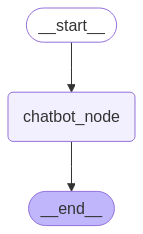

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import HumanMessage, AIMessage
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def chat_model_node(state: State):
    # Return the LLM's response in the correct state format
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

Definimos la función para imprimir los mensajes del grafo.

In [3]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str, config: dict):
    # Initialize a flag to track if an assistant response has been printed
    assistant_response_printed = False

    # Print the user's input immediately
    print(f"\n\n{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
    
    # Create the user's message with the HumanMessage class
    user_message = HumanMessage(content=user_input)
    
    # Stream events from the graph execution
    for event in graph.stream({"messages": [user_message]}, config, stream_mode="values"):
        # event is a dictionary mapping node names to their output
        # Example: {'chatbot_node': {'messages': [...]}} or {'summarize_conversation_node': {'summary': '...'}}

        # Iterate through node name and its output
        for node_name, value in event.items():
            # Check if this event is from the chatbot node which should contain the assistant's reply
            if node_name == 'messages':
                # Ensure the output format is as expected (list of messages)
                if isinstance(value, list):
                    # Get the messages from the event
                    messages = value
                    # Ensure 'messages' is a non-empty list
                    if isinstance(messages, list) and messages:
                        # Get the last message (presumably the assistant's reply)
                        last_message = messages[-1]
                        # Ensure the message is an instance of AIMessage
                        if isinstance(last_message, AIMessage):
                            # Ensure the message has content to display
                            if hasattr(last_message, 'content'):
                                # Print the assistant's message content
                                print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{last_message.content}")
                                assistant_response_printed = True # Mark that we've printed the response
    
    # Fallback if no assistant response was printed (e.g., graph error before chatbot_node)
    if not assistant_response_printed:
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}[No response generated or error occurred]")

Ejecutamos el grafo

In [4]:
USER1_THREAD_ID = "USER1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}
while True:
    user_input = input(f"\n\nUser: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print(f"{COLOR_GREEN}User: {COLOR_RESET}Exiting...")
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
        break
    
    events = stream_graph_updates(user_input, config_USER1)



User: Hello, my name is Máximo
Assistant: Hello Máximo! It's a pleasure to meet you. How can I assist you today?
User: Exiting...
Assistant: Goodbye!


Como se puede ver solo le he dicho cómo me llamo

Ahora reiniciamos el notebook para que se eliminen todos los datos guardados en RAM del notebook y volvemos a ejecutar el código anterior.

Volvemos a crear la memoria de `sqlite` con `SqliteSaver`

In [1]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
import os

# Create the directory if it doesn't exist
os.makedirs("state_db", exist_ok=True)

db_path = "state_db/langgraph_sqlite.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

Volvemos a crear el grafo

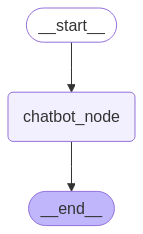

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import HumanMessage, AIMessage
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def chat_model_node(state: State):
    # Return the LLM's response in the correct state format
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

Volvemos a definir la función para imprimir los mensajes del grafo.

In [3]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str, config: dict):
    # Initialize a flag to track if an assistant response has been printed
    assistant_response_printed = False

    # Print the user's input immediately
    print(f"\n\n{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
    
    # Create the user's message with the HumanMessage class
    user_message = HumanMessage(content=user_input)
    
    # Stream events from the graph execution
    for event in graph.stream({"messages": [user_message]}, config, stream_mode="values"):
        # event is a dictionary mapping node names to their output
        # Example: {'chatbot_node': {'messages': [...]}} or {'summarize_conversation_node': {'summary': '...'}}

        # Iterate through node name and its output
        for node_name, value in event.items():
            # Check if this event is from the chatbot node which should contain the assistant's reply
            if node_name == 'messages':
                # Ensure the output format is as expected (list of messages)
                if isinstance(value, list):
                    # Get the messages from the event
                    messages = value
                    # Ensure 'messages' is a non-empty list
                    if isinstance(messages, list) and messages:
                        # Get the last message (presumably the assistant's reply)
                        last_message = messages[-1]
                        # Ensure the message is an instance of AIMessage
                        if isinstance(last_message, AIMessage):
                            # Ensure the message has content to display
                            if hasattr(last_message, 'content'):
                                # Print the assistant's message content
                                print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{last_message.content}")
                                assistant_response_printed = True # Mark that we've printed the response
    
    # Fallback if no assistant response was printed (e.g., graph error before chatbot_node)
    if not assistant_response_printed:
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}[No response generated or error occurred]")

Y lo volvemos a ejecutar

In [5]:
USER1_THREAD_ID = "USER1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}
while True:
    user_input = input(f"\n\nUser: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print(f"{COLOR_GREEN}User: {COLOR_RESET}Exiting...")
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
        break
    
    events = stream_graph_updates(user_input, config_USER1)



User: What's my name?
Assistant: Your name is Máximo. It's nice to know and use your name as we chat. How can I assist you today, Máximo?
User: Exiting...
Assistant: Goodbye!


Como se puede ver, hemos podido recuperar el estado del grafo de la base de datos SQlite.

## Human in the loop

Aunque un agente puede realizar tareas, para según que tareas, es necesario que haya una supervisión humana. A esto se le llama `human in the loop`. Así que vamos a ver cómo se puede hacer esto con `LangGraph`.

La capa de [persistencia](https://langchain-ai.github.io/langgraph/concepts/persistence/) de `LangGraph` admite flujos de trabajo con humanos en el bucle, lo que permite que la ejecución se detenga y reanude en función de los comentarios de los usuarios. La interfaz principal de esta funcionalidad es la función [interrupt](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#interrupt). Llamando a `interrupt` dentro de un nodo se detendrá la ejecución. La ejecución se puede reanudar, junto con la nueva aportación del humano, pasada en una primitiva [Command](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#the-command-primitive). `interrupt` es similar al comando de Python `input()`, pero con algunas consideraciones extra.

Vamos a repetir el código anterior, pero haremos un cambio, que es agregar una simple herramienta `human_assistance`. Esta herramienta utiliza `interrupt` para recibir información de un humano.

Primero cargamos los valores de las API KEYs

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

Creamos el grafo

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

Definimos la `tool` de búsqueda

In [3]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

Ahora creamos la `tool` de ayuda humana

In [4]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]

`LangGraph` obtiene información de las herramientas mediante la documentación de la herramienta, es decir, el docstring de la función. Por lo que es muy importante generar un buen docstring para la herramienta.

Creamos una lista de `tools`

In [5]:
tools_list = [search_tool, human_assistance]

A continuación el `LLM` con las `bind_tools` y lo añadimos al grafo

In [6]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM
login(token=HUGGINGFACE_TOKEN)
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Si te fijas, hemos cambiado la forma de definir la función `chatbot_function`, ya que ahora tiene que manejar la interrupción.

Añadimos la `tool_node` al grafo

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [8]:
graph_builder.add_edge(START, "chatbot_node")

Creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Compilamos el grafo con el `checkpointer`

In [10]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

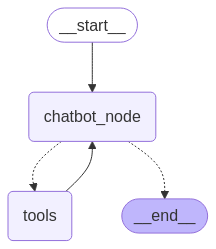

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Ahora solicitemos el chatbot con una pregunta que involucrará a la nueva herramienta `human_assistance`:

In [12]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need some expert guidance for building an AI agent. Could you provide me with some advice?


Como se puede ver, el chatbot generó una llamada de herramienta de asistencia humana.

``` markdown
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need some expert guidance for building an AI agent. Could you provide advice on key considerations, best practices, and potential pitfalls to avoid?
```

pero luego la ejecución se ha interrumpido. Vamos a ver el estado del grafo

In [13]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Vemos que se detuvo en el nodo de `tools`. Analizamos cómo se ha definido la herramienta `human_assistance`.

``` python
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]
```

Llamando a la herramienta `interrupt` se detendrá la ejecución, similar al la función de Python `input()`.

El progreso se mantiene en función de nuestra elección de [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). Es decir, la elección de dónde se guarda el estado del grafo. Así que si estamos persistiendo (guardando el estado del grafo) con una base de datos como `SQlite`, `Postgres`, etc, podemos reanudar la ejecución en cualquier momento siempre y cuando la base de datos esté viva.

Aquí estamos persistiendo (guardando el estado del grafo) con el puntero de verificación en memoria, por lo que podemos reanudar en cualquier momento mientras nuestro kernel de Python se esté ejecutando. En mi caso, mientras no resetee el kernel de mi Jupyter Notebook.

Para reanudar la ejecución, pasamos un objeto [Command](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#the-command-primitive) que contiene los datos esperados por la herramienta. El formato de estos datos se puede personalizar en función de nuestras necesidades. Aquí, solo necesitamos un diccionario con una key `data`

In [14]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need some expert guidance for building an AI agent. Could you provide me with some advice?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend checking out LangGraph for building your AI agent. It's known for being more reliable and extensible compared to simple autonomous agents.


Como vemos, el chatbot ha esperado a que un humano le proporcione la respuesta y luego ha generado una respuesta basada en la información recibida. Le hemos pedido por la ayuda sobre un experto sobre cómo crear agentes, el humano le ha dicho que lo mejor es usar LangGraph, y el chatbot ha generado una respuesta basada en esa información.

Pero sigue teniendo la posibilidad de realizar búsquedas en la web. Así que ahora le vamos a pedir las últimas noticias sobre LangGraph.

In [15]:
user_input = "What's the latest news about LangGraph?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What's the latest news about LangGraph?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: latest news LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangChain - Changelog", "url": "https://changelog.langchain.com/", "content": "LangGraph `interrupt`: Simplifying human-in-the-loop agents --------------------------------------------------- Our latest feature in LangGraph, interrupt , makes building human-in-the-loop workflows easier. Agents aren’t perfect, so keeping humans “in the loop”... December 16, 2024 [...] LangGraph 🔁 Modify graph state from tools in LangGraph --------------------------------------------- LangGraph's latest update gives you greater control over your agents by enabling tools to directly upd

Ha buscado las últimas noticias sobre LangGraph y ha generado una respuesta basada en la información recibida.

### Más

### Aprobación del uso de herramientas

 > Nota: Este apartado lo vamos a hacer usando Sonnet 3.7, ya que a día de la escritura del post, es el mejor modelo para uso con agentes, y es el único que entiende cuando tiene que llamar a las tools y cuando no para este ejemplo

Podemos meter un `human in the loop` para aprobar el uso de herramientas. Vamos a crear un chatbot con varias herramientas para hacer oepraciones matemáticas

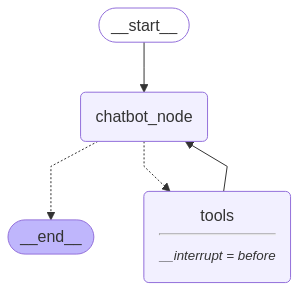

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langchain_anthropic import ChatAnthropic
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int

    Returns:
        The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int

    Returns:
        The sum of a and b.
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int

    Returns:
        The difference between a and b.
    """
    return a - b

@tool
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int

    Returns:
        The quotient of a and b.
    """
    return a / b

tools_list = [multiply, add, subtract, divide]

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)
llm_with_tools = llm.bind_tools(tools_list)

# Nodes
def chat_model_node(state: State):
    system_message = "You are a helpful assistant that can use tools to answer questions. Once you have the result of a tool, provide a final answer without calling more tools."
    messages = [SystemMessage(content=system_message)] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)
tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile(interrupt_before=["tools"], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, config, stream_mode="updates"):
    if 'chatbot_node' in event:
        print(event['chatbot_node']['messages'][-1].pretty_print())
    else:
        print(event)

================================== Ai Message ==================================

[{'text': "I'll multiply 2 and 3 for you.", 'type': 'text'}, {'id': 'toolu_01QDuind1VBHWtvifELN9SPf', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01QDuind1VBHWtvifELN9SPf)
 Call ID: toolu_01QDuind1VBHWtvifELN9SPf
  Args:
    a: 2
    b: 3
None
{'__interrupt__': ()}


Como podemos ver el LLM sabe que tiene que usar la herramienta `multiply`, pero se interrumpe la ejecución, porque tiene que esperar a que un humano le autorice el uso de la herramienta.

Podemos ver el estado en el que se ha quedado el grafo

In [3]:
state = graph.get_state(config)
state.next

('tools',)

Como vemos se ha quedado en el nodo de `tools`.

Podemos crear una función que le pida al usuario que apruebe el uso de la herramienta.

Creamos un nuevo `thread_id` para que se cree un nuevo estado.

In [51]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

config = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, config, stream_mode="updates"):
    function_name = None
    function_args = None

    if 'chatbot_node' in event:
        for element in event['chatbot_node']['messages'][-1].content:
            if element['type'] == 'text':
                print(element['text'])
            elif element['type'] == 'tool_use':
                function_name = element['name']
                function_args = element['input']
                print(f"The LLM wants to use the tool {function_name} with the arguments {function_args}")
    
    elif '__interrupt__' in event:
        pass
    
    else:
        print(event)

question = f"Do you approve the use of the tool {function_name} with the arguments {function_args}? (y/n)"
user_approval = input(question)
print(f"{question}: {user_approval}")

if user_approval.lower() == 'y':
    print("User approved the use of the tool")
    for event in graph.stream(None, config, stream_mode="updates"):
        if 'chatbot_node' in event:
            for element in event['chatbot_node']['messages'][-1].content:
                if isinstance(element, str):
                    print(element, end="")
        
        elif 'tools' in event:
            result = event['tools']['messages'][-1].content
            tool_used = event['tools']['messages'][-1].name
            print(f"The result of the tool {tool_used} is {result}")
        
        else:
            print(event)


I'll multiply 2 and 3 for you.
The LLM wants to use the tool multiply with the arguments {'a': 2, 'b': 3}
Do you approve the use of the tool None with the arguments None? (y/n): y
User approved the use of the tool
The result of the tool multiply is 6
The result of multiplying 2 and 3 is 6.

Podemos ver que el grafo ha terminado viendo el estado del grafo.

In [52]:
state = graph.get_state(config)
state.next

()

## Personalización del estado

 > Nota: Este apartado lo vamos a hacer usando Sonnet 3.7, ya que a día de la escritura del post, es el mejor modelo para uso con agentes, y es el único que entiende cuando tiene que llamar a las tools y cuando no

Hasta ahora, hemos confiado en un estado simple con una entrada, una lista de mensajes. Se puede llegar lejos con este estado simple, pero si se desea definir un comportamiento complejo sin depender de la lista de mensajes, se pueden agregar campos adicionales al estado.

Aquí vamos a ver un nuevo escenario, en el que el chatbot está utilizando la herramienta de búsqueda para encontrar información específica, y reenviándola a un ser humano para su revisión. Vamos a hacer que el chatbot investigue el cumpleaños de una entidad. Agregaremos `name` y `birthday` claves del estado.

Primero cargamos los valores de las API KEYs

In [1]:
import os
import dotenv

dotenv.load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

Creamos el nuevo estado

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

Agregar esta información al estado hace que sea fácilmente accesible por otros nodos del grafo (por ejemplo, un nodo downstram que almacena o procesa la información), así como la capa de persistencia del grafo.

Ahora creamos el grafo

In [3]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

Definimos la `tool` de búsqueda

In [4]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

Ahora creamos la tool de asistencia humana. En esta tool rellenaremos las claves de estado dentro de nuestra herramienta `human_assistance`. Esto permite a un ser humano revisar la información antes de que se almacene en el estado. Volveremos a usar `Command`, esta vez para emitir una actualización de estado desde el interior de nuestra herramienta.

In [5]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )

    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"

    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

Hemos usado [ToolMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.tool.ToolMessage.html) que se usa para pasar el resultado de ejecutar una `tool` de nuevo a un modelo y [InjectedToolCallId](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.InjectedToolCallId.html)

Creamos una lista de `tools`

In [6]:
tools_list = [search_tool, human_assistance]

A continuación el `LLM` con las `bind_tools` y lo añadimos al grafo

In [7]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_anthropic import ChatAnthropic


# Create the LLM
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Añadimos la `tool` al grafo

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [9]:
graph_builder.add_edge(START, "chatbot_node")

Creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Compilamos el grafo con el `checkpointer`

In [11]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

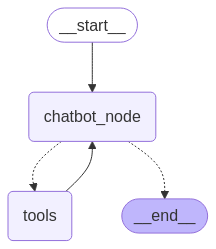

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Vamos a pedir a nuestro chatbot que busque el "cumpleaños" de la biblioteca de `LangGraph`.

Dirigiremos al chatbot hata la herramienta `human_assistance` una vez que tenga la información requerida. Los argumentos `name` y `birthday` son obligatorios para la herramienta `human_assistance`, así que obligan al chatbot a generar propuestas para estos campos.

In [13]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'text': "I'll help you look up when LangGraph was released, and then I'll use the human_assistance tool for review as requested.\n\nFirst, let me search for information about LangGraph's release date:", 'type': 'text'}, {'id': 'toolu_011KHWFxYbFnUvGEF6MPt3dE', 'input': {'query': 'LangGraph release date when was LangGraph released'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_011KHWFxYbFnUvGEF6MPt3dE)
 Call ID: toolu_011KHWFxYbFnUvGEF6MPt3dE
  Args:
    query: LangGraph release date when was LangGraph released


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Studio: The first agent IDE | by Bhavik Jikadara - Medium", "url": "https://bhavikjikadara.medium.com/langgraph-studio-the-first-agent-ide-468132628274", "content": "LangGraph, launched in January 2023, is a low-level orchestration framework designed for building controllable and complex agentic applications.", "score": 0.80405265}, {"title": "langgraph - PyPI", "url": "https://pypi.org/project/langgraph/", "content": "langgraph · PyPI\nSkip to main content Switch to mobile version\n\nSearch PyPI  Search\n\nHelp\nSponsors\nLog in\nRegister\n\nMenu\n\nHelp\nSponsors\nLog in\nRegister\n\nSearch PyPI  Search\nlanggraph 0.2.70\npip install langgraph Copy PIP instructions\nLatest versionReleased: Feb 6, 2025\nBuilding stateful, multi-actor applications with LLMs\nNavigation\n\nProject description\nRelease history\nDownload files [...] 0.2.20 Sep 13, 2024\n

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'text': 'Based on my search, I found that LangGraph was launched in January 2023. However, I noticed some inconsistencies in the information, as one source mentions it was launched in January 2023, while the PyPI page shows a version history starting from 2024.\n\nLet me request human assistance to verify this information:', 'type': 'text'}, {'id': 'toolu_019EopKn8bLi3ksvUVY2Mt5p', 'input': {'name': 'LangGraph', 'birthday': 'January 2023'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_019EopKn8bLi3ksvUVY2Mt5p)
 Call ID: toolu_019EopKn8bLi3ksvUVY2Mt5p
  Args:
    name: LangGraph
    birthday: January 2023


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart i

Se ha parado por el `interrupt` en la herramienta `human_assistance`. En este caso, el chatbot no identificó la fecha correcta, por lo que podemos introducirla nosotros mismos.

In [14]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': 'Based on my search, I found that LangGraph was launched in January 2023. However, I noticed some inconsistencies in the information, as one source mentions it was launched in January 2023, while the PyPI page shows a version history starting from 2024.\n\nLet me request human assistance to verify this information:', 'type': 'text'}, {'id': 'toolu_019EopKn8bLi3ksvUVY2Mt5p', 'input': {'name': 'LangGraph', 'birthday': 'January 2023'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_019EopKn8bLi3ksvUVY2Mt5p)
 Call ID: toolu_019EopKn8bLi3ksvUVY2Mt5p
  Args:
    name: LangGraph
    birthday: January 2023
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

Thank 

In [15]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

### Actualización manual del estado

LangGraph proporciona un alto grado de control sobre el estado de aplicación. Por ejemplo, en cualquier punto (incluso cuando se interrumpe), podemos soreescribir manualmente una key del estado usando `graph.update_state`:

Vamos a actualizar el `name` del estado a `LangGraph (library)`.

In [16]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f010a5a-8a70-618e-8006-89107653db68'}}

Si ahora vemos el estado con `graph.get_state(config)` veremos que el `name` se ha actualizado.

In [17]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

Las actualizaciones de estado manuales generarán una traza en `LangSmith`. Se pueden usar para controlar flujos de trabajo de `human in the loop`, como se puede ver en esta [guía](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/).

## Checkpoints

En un flujo de trabajo típico de un chatbot, el usuario interactúa con el chatbot una o más veces para realizar una tarea. En las secciones anteriores, vimos cómo agregar memoria y un `human in the loop` para poder verificar nuestro estado de gráfico y controlar las respuestas futuras.

Pero, a lo mejor un usuario quiere comenzar desde una respuesta anterior y o quiere `ramificar` para explorar un resultado separado. Esto es útil para aplicaciones de agentes, cuando un flujo falla pueden volver a un checkpoint anterior y probar otra estrategia.

`LangGraph` da esta posibilidad mediante los `checkpoints`

Primero cargamos los valores de las API KEYs

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

Creamos el nuevo estado

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

Ahora creamos el grafo

In [3]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

Definimos la `tool` de búsqueda

In [4]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

Creamos una lista de `tools`

In [5]:
tools_list = [search_tool]

A continuación el `LLM` con las `bind_tools` y lo añadimos al grafo

In [7]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing


# Create the LLM
login(token=HUGGINGFACE_TOKEN)
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Añadimos la `tool` al grafo

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [9]:
graph_builder.add_edge(START, "chatbot_node")

Creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Compilamos el grafo con el `checkpointer`

In [11]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

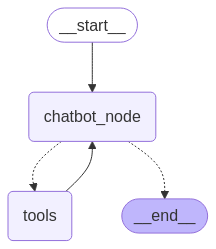

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Hagamos que nuestro gráfico dé un par de pasos. Cada paso será guardado en el historial del estado.

Hacemos la primera llamada al modelo

In [13]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabi

Y ahora la segunda llamada

In [14]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like a great idea! LangGraph's capabilities in state management and multi-agent coordination will be very useful for building an autonomous agent. I recommend starting with the official documentation and tutorials to get a better understanding of how to use LangGraph effectively. If you need any more help or have specific questions, feel free to ask!


Ahora que hemos hecho dos llamadas al modelo, vamos a ver el historial del estado.

In [15]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 2:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  20 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  19 Next:  ('chatbot_node',)
--------------------------------------------------------------------------------
Num Messages:  18 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  18 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  17 Next:  ('chatbot_node',)
--------------------------------------------------------------------------------
Num Messages:  16 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  15 Next:  ('chatbot_node',)
--------------------------------------------------------------------------------
Num Messages:  14 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  13 Next:  ('chatbot_node',)
------------

Hemos guardado en `to_replay` el estado del grafo en cada iteración. Podemos volver a un estado pasado y continuar el flujo desde allí.

Para reanudar el flujo en ese estado hay que usar el método `next`

In [16]:
print(to_replay.next)

('tools',)


La configuración del checkpoint contiene el `checkpoint_id`, que es un timestamp del flujo

In [17]:
print(to_replay.config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f010a5f-3cc6-6cb2-8001-5347dc22345b'}}


Dando este `checkpoint_id` a `LangGrah` carga el estado en ese momento del flujo

In [18]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, [...] [](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelinen

El grafo reanudó la ejecución desde el nodo `tool calls`.